Loads the raw TAD videos, checks folder structure, counts videos per class/split, shows a few example frames, and verifies that the dataset is usable.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

DATA_ROOT = "/content/drive/MyDrive/traffic-accident-edge/TAD-benchmark"  # adjust if needed
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))
print("TRAIN_DIR exists:", os.path.exists(TRAIN_DIR))
print("TEST_DIR exists:", os.path.exists(TEST_DIR))

for root, dirs, files in os.walk(DATA_ROOT):
    print("ROOT:", root)
    print("  dirs:", dirs[:10])
    print("  files:", files[:10])
    break

Mounted at /content/drive
DATA_ROOT exists: True
TRAIN_DIR exists: True
TEST_DIR exists: True
ROOT: /content/drive/MyDrive/traffic-accident-edge/TAD-benchmark
  dirs: ['test', 'train']
  files: ['.DS_Store']


In [2]:
import glob

# train
train_accident_dirs = [
    os.path.join(TRAIN_DIR, "accident_1"),
    os.path.join(TRAIN_DIR, "accident_2"),
    os.path.join(TRAIN_DIR, "accident_3"),
    os.path.join(TRAIN_DIR, "accident_4"),
]
train_normal_dir = os.path.join(TRAIN_DIR, "normal")

train_accident_videos = []
for d in train_accident_dirs:
    vids = glob.glob(os.path.join(d, "*.mp4")) + glob.glob(os.path.join(d, "*.avi"))
    train_accident_videos.extend(vids)

train_normal_videos = glob.glob(os.path.join(train_normal_dir, "*.mp4")) + \
                      glob.glob(os.path.join(train_normal_dir, "*.avi"))

print("Train accident videos:", len(train_accident_videos))
print("Train normal videos:", len(train_normal_videos))

# test
test_accident_dir = os.path.join(TEST_DIR, "accident")
test_normal_dir   = os.path.join(TEST_DIR, "normal")

test_accident_videos = glob.glob(os.path.join(test_accident_dir, "*.mp4")) + \
                       glob.glob(os.path.join(test_accident_dir, "*.avi"))
test_normal_videos   = glob.glob(os.path.join(test_normal_dir, "*.mp4")) + \
                       glob.glob(os.path.join(test_normal_dir, "*.avi"))

print("Test accident videos:", len(test_accident_videos))
print("Test normal videos:", len(test_normal_videos))

print("Example train accident:", train_accident_videos[0] if train_accident_videos else None)
print("Example train normal:", train_normal_videos[0] if train_normal_videos else None)


Train accident videos: 261
Train normal videos: 111
Test accident videos: 16
Test normal videos: 16
Example train accident: /content/drive/MyDrive/traffic-accident-edge/TAD-benchmark/train/accident_1/video3.mp4
Example train normal: /content/drive/MyDrive/traffic-accident-edge/TAD-benchmark/train/normal/20220518_acci-bg6.mp4


In [3]:
import cv2
import matplotlib.pyplot as plt

def show_some_frames(video_path, num_frames=4):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total == 0:
        print("No frames in", video_path)
        return

    step = max(total // num_frames, 1)

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

    cap.release()

    plt.figure(figsize=(12, 3))
    for i, f in enumerate(frames):
        plt.subplot(1, len(frames), i+1)
        plt.imshow(f)
        plt.axis("off")
    plt.show()

Train accident sample:


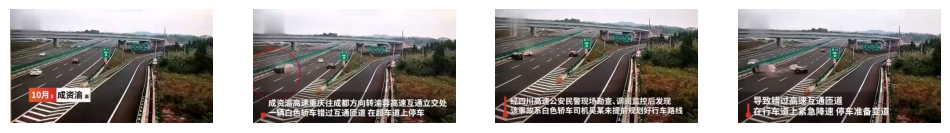

Train normal sample:


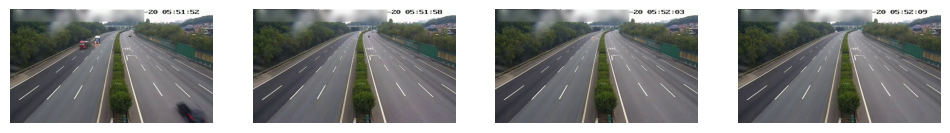

In [4]:
print("Train accident sample:")
show_some_frames(train_accident_videos[0])

print("Train normal sample:")
show_some_frames(train_normal_videos[0])

In [5]:
non_video_files = []
for root, dirs, files in os.walk(DATA_ROOT):
    for f in files:
        if not (f.endswith(".mp4") or f.endswith(".avi") or f.endswith(".mov")):
            non_video_files.append(os.path.join(root, f))

len(non_video_files), non_video_files[:20]

(3,
 ['/content/drive/MyDrive/traffic-accident-edge/TAD-benchmark/.DS_Store',
  '/content/drive/MyDrive/traffic-accident-edge/TAD-benchmark/test/.DS_Store',
  '/content/drive/MyDrive/traffic-accident-edge/TAD-benchmark/train/.DS_Store'])

### Task Definition (Version 1)

Dataset: `TAD-benchmark` (in Google Drive), with:
- 261 training accident videos, 111 training normal videos,
- 16 test accident videos, 16 test normal videos.

Labels are given by folder structure:
- `train/accident_*` and `test/accident` → accident (positive),
- `train/normal` and `test/normal` → normal (negative).

For our first experiments we define **clip-level accident detection**:
- Each sample will be a fixed-length clip of `T` consecutive frames from a video.
- Clips from accident videos are labeled 1 (accident), clips from normal videos are labeled 0 (normal).
- We will evaluate Precision, Recall, F1-score, and later time-to-detection.


In [6]:
print("Train accident:", len(train_accident_videos))
print("Train normal:", len(train_normal_videos))
print("Test accident:", len(test_accident_videos))
print("Test normal:", len(test_normal_videos))


Train accident: 261
Train normal: 111
Test accident: 16
Test normal: 16


In [7]:
import cv2
def video_length(path):
    cap = cv2.VideoCapture(path)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 1
    cap.release()
    return frames, fps, frames / fps

for v in train_accident_videos[:3]:
    f, fps, sec = video_length(v)
    print(os.path.basename(v), "frames:", f, "fps:", fps, "seconds:", round(sec, 1))


video3.mp4 frames: 773 fps: 25.0 seconds: 30.9
video7.mp4 frames: 383 fps: 25.0 seconds: 15.3
video8.mp4 frames: 623 fps: 25.0 seconds: 24.9


In [8]:
import random
random.seed(42)

def split_list(lst, train_ratio=0.8):
    lst = lst.copy()
    random.shuffle(lst)
    n_train = int(train_ratio * len(lst))
    return lst[:n_train], lst[n_train:]

acc_train, acc_val = split_list(train_accident_videos, train_ratio=0.8)
norm_train, norm_val = split_list(train_normal_videos, train_ratio=0.8)

print("Accident train:", len(acc_train), "val:", len(acc_val))
print("Normal   train:", len(norm_train), "val:", len(norm_val))


Accident train: 208 val: 53
Normal   train: 88 val: 23


In [9]:
import json

splits = {
    "acc_train": acc_train,
    "acc_val": acc_val,
    "norm_train": norm_train,
    "norm_val": norm_val,
    "acc_test": test_accident_videos,
    "norm_test": test_normal_videos,
}

with open(os.path.join(DATA_ROOT, "splits.json"), "w") as f:
    json.dump(splits, f, indent=2)


### Phase 1 Summary

- Confirmed dataset structure: `train/accident_*`, `train/normal`, `test/accident`, `test/normal`.
- Collected full lists of video paths for each class and split.
- Verified that there are no extra text annotations; labels are defined by folder structure only.
- Visualized sample accident and normal videos to understand the data.
- Defined Task Definition v1: clip-level accident vs normal classification.
- Created train/validation/test splits and saved them to `splits.json` for later use.
